In [22]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Load the Excel file
file_path = 'pil_test.xlsx'  # Update the path if the file is located elsewhere
df = pd.read_excel(file_path)

# Check the first few rows of the data to ensure it's loaded correctly
print(df.head())

   Unnamed: 0  Zaman  Maxell     GP  Fujitsu  Duracell
0         NaN    0.0   3.307  3.301    3.287     3.238
1         NaN    0.0   3.307  3.301    3.287     3.238
2         NaN    1.0   3.307  3.301    3.287     3.240
3         NaN    3.0   3.112  3.035    3.091     3.071
4         NaN    5.0   3.066  3.015    3.051     3.039


In [24]:
print(df.isna().sum())

Unnamed: 0    6370
Zaman          315
Maxell         317
GP             315
Fujitsu          0
Duracell       372
dtype: int64


In [25]:
print(f"Number of rows remaining: {df.shape[0]}")

Number of rows remaining: 6370


In [26]:
df = df.drop(columns=['Unnamed: 0'])
print(df.isna().sum())

Zaman       315
Maxell      317
GP          315
Fujitsu       0
Duracell    372
dtype: int64


In [27]:
print(f"Number of rows remaining: {df.shape}")
print(df)

Number of rows remaining: (6370, 5)
      Zaman  Maxell     GP  Fujitsu  Duracell
0       0.0   3.307  3.301    3.287     3.238
1       0.0   3.307  3.301    3.287     3.238
2       1.0   3.307  3.301    3.287     3.240
3       3.0   3.112  3.035    3.091     3.071
4       5.0   3.066  3.015    3.051     3.039
...     ...     ...    ...      ...       ...
6365    NaN     NaN    NaN    1.804       NaN
6366    NaN     NaN    NaN    1.802       NaN
6367    NaN     NaN    NaN    1.803       NaN
6368    NaN     NaN    NaN    1.802       NaN
6369    NaN     NaN    NaN    1.800       NaN

[6370 rows x 5 columns]


In [28]:
# Make a copy of the dataframe
df_interp = df.copy()

# Check if there are any NaN values in 'Zaman'
if df_interp['Zaman'].isna().any():
    # Get the last non-null value in 'Zaman'
    last_valid_value = df_interp['Zaman'].ffill().iloc[-1]
    
    # Identify NaN rows in 'Zaman' column
    nan_mask = df_interp['Zaman'].isna()
    nan_indices = df_interp.index[nan_mask]
    num_nans = len(nan_indices)
    
    # Generate the sequence starting from last_valid_value + 2 with step 2
    fill_values = np.arange(last_valid_value + 2, 
                          last_valid_value + 2 + 2*num_nans, 
                          2)
    
    # Fill the NaN values
    df_interp.loc[nan_indices, 'Zaman'] = fill_values
    
    print("\nCustom Increment for Zaman:")
    print(df_interp)
else:
    print("No NaN values found in 'Zaman' column")


Custom Increment for Zaman:
        Zaman  Maxell     GP  Fujitsu  Duracell
0         0.0   3.307  3.301    3.287     3.238
1         0.0   3.307  3.301    3.287     3.238
2         1.0   3.307  3.301    3.287     3.240
3         3.0   3.112  3.035    3.091     3.071
4         5.0   3.066  3.015    3.051     3.039
...       ...     ...    ...      ...       ...
6365  12752.0     NaN    NaN    1.804       NaN
6366  12754.0     NaN    NaN    1.802       NaN
6367  12756.0     NaN    NaN    1.803       NaN
6368  12758.0     NaN    NaN    1.802       NaN
6369  12760.0     NaN    NaN    1.800       NaN

[6370 rows x 5 columns]


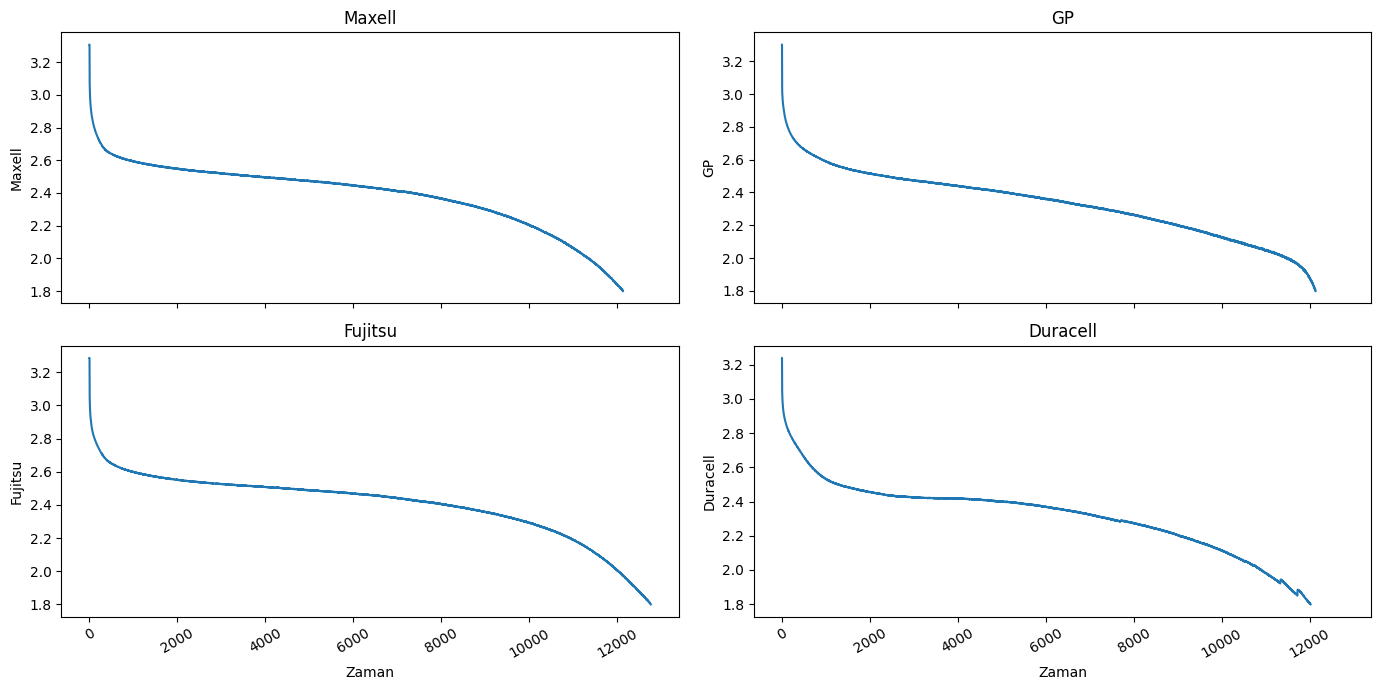

In [29]:
def data_plot(df):
    # Make a copy
    df_plot = df.copy()

    # Set 'zaman' as the x-axis
    x = df_plot['Zaman']
    df_plot = df_plot.drop(columns=['Zaman'])  # Only battery columns now

    ncols = 2
    nrows = (df_plot.shape[1] + ncols - 1) // ncols  # Better way to calculate rows

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7), sharex=True)

    axes = axes.flatten()  # Flatten in case of (2,2) axes array

    for i, col in enumerate(df_plot.columns):
        sns.lineplot(x=x, y=df_plot[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", rotation=30)

    # Hide empty plots if any
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    fig.tight_layout()
    plt.show()

# Call the function
data_plot(df_interp)

In [30]:
voltage_combined = np.concatenate([
    df['Maxell'].dropna().values,
    df['GP'].dropna().values,
    df['Fujitsu'].dropna().values,
    df['Duracell'].dropna().values
])

In [31]:
print("Number of NaN values:", np.isnan(voltage_combined).sum())

Number of NaN values: 0


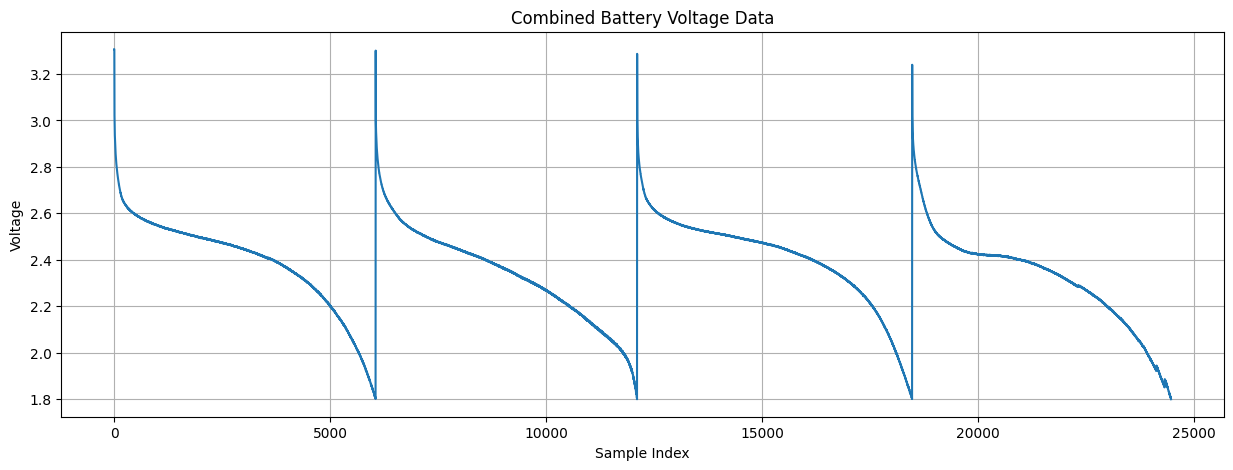

In [32]:

plt.figure(figsize=(15,5))
plt.plot(voltage_combined)
plt.title('Combined Battery Voltage Data')
plt.xlabel('Sample Index')
plt.ylabel('Voltage')
plt.grid(True)
plt.show()


In [33]:
train_size = int(0.7 * len(voltage_combined))
val_size = int(0.15 * len(voltage_combined))
train_data, val_data, test_data = voltage_combined[:train_size], voltage_combined[train_size:train_size+val_size], voltage_combined[train_size+val_size:]

In [34]:
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Step 1: Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))


# Fit the scaler on the training data only
scaler.fit(train_data)  # This learns the scaling parameters from the training data

# Step 2: Transform the training, validation, and test data
scaled_train = scaler.transform(train_data).flatten()   # Transform the training data
scaled_val = scaler.transform(val_data).flatten()     # Transform the validation data
scaled_test = scaler.transform(test_data).flatten()    # Transform the test data

# Print the first few scaled values
print(scaled_train[:5])
print(scaled_val[:5])
print(scaled_test[:5])


[1.         1.         1.         0.87068966 0.84018568]
[0.32360743 0.32228117 0.32228117 0.32228117 0.32360743]
[0.40384615 0.40318302 0.40384615 0.40450928 0.40384615]


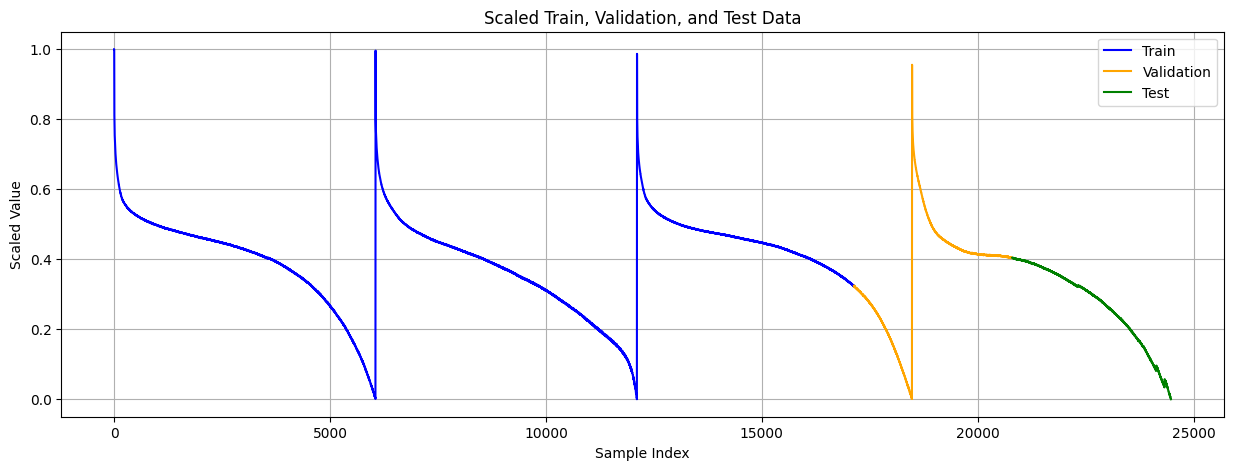

In [35]:
# Create a figure
plt.figure(figsize=(15, 5))

# Plot training data
plt.plot(scaled_train, label='Train', color='blue')

# Plot validation data
plt.plot(range(len(scaled_train), len(scaled_train) + len(scaled_val)), scaled_val, label='Validation', color='orange')

# Plot test data
plt.plot(range(len(scaled_train) + len(scaled_val), len(scaled_train) + len(scaled_val) + len(scaled_test)), scaled_test, label='Test', color='green')

# Decorations
plt.title('Scaled Train, Validation, and Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Create sequences and labels for training data
sequence_length = 67  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences and labels for testing data
sequence_length = 67  # Number of time steps to look back
X_val, y_val = [], []
for i in range(len(scaled_val) - sequence_length):
    X_val.append(scaled_val[i:i + sequence_length])
    y_val.append(scaled_val[i + sequence_length])  # Predicting the value right after the sequence
X_val, y_test = np.array(X_val), np.array(y_val)

# Create sequences and labels for testing data
sequence_length = 67  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)



In [37]:

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
print(X_val.shape, y_val.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([17066, 67]) torch.Size([17066])
torch.Size([3604, 67]) torch.Size([3604])
torch.Size([3605, 67]) torch.Size([3605])


In [38]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader for batching
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 67, 1]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection

Batch x shape: torch.Size([32, 67])
Batch y shape: torch.Size([32])
